In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [132]:
data = pd.read_csv('glass.data', names=['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'])
data = data.drop(columns=['Id'])
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


**Пропуски відсутні, категоріальні фічі теж**

<Axes: >

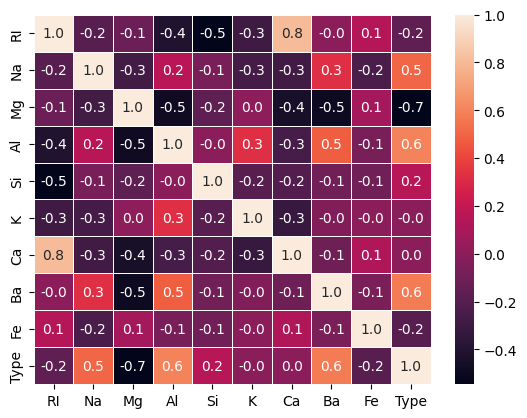

In [134]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, linewidth=.5, robust=True, fmt=".1f")


**Ca i RI сильна кореляція, видалемо Ca бо в нього відсутня жодна кореляція з таргетом**

<Axes: >

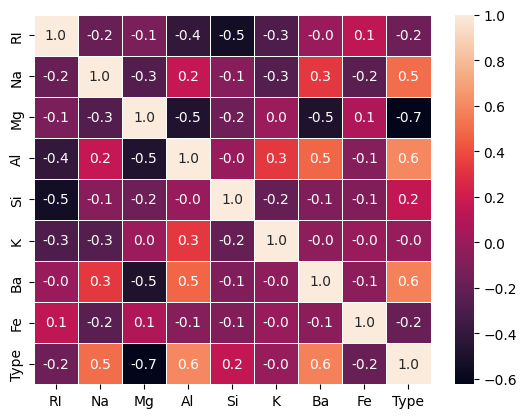

In [135]:
data = data.drop(columns='Ca')
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, linewidth=.5, robust=True, fmt=".1f")

In [136]:
data['Type'].value_counts(sort=False)

Type
1    70
2    76
3    17
5    13
6     9
7    29
Name: count, dtype: int64

**4 клас відсутній. По іншим класам будемо робити oversampling бо даних і так мало**

In [137]:
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(data.drop(columns=['Type']))
X_train, X_test, y_train, y_test = train_test_split(data_sc, data.Type, random_state=17, train_size=0.66, shuffle=True)

In [150]:
clf = LogisticRegression(random_state=17, solver='saga', max_iter=10000).fit(X_train,y_train)
# clf = OneVsRestClassifier(LogisticRegression(random_state=42, solver='saga', max_iter=10000)).fit(X_train, y_train)
cv_sc = cross_val_score(clf, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [0.52777778 0.57142857 0.51428571 0.57142857]


**На крос валідації датасет поводиться збалансовано**

In [151]:
clf.fit(X_train, y_train)

print(f'Train Score: {clf.score(X_train, y_train)}')
print(f'Test Score: {clf.score(X_test, y_test)}')

Train Score: 0.574468085106383
Test Score: 0.4794520547945205


**Трохи перетреновано**

In [156]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.36      1.00      0.53        16
           2       0.62      0.27      0.37        30
           3       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         2
           7       0.69      1.00      0.81        11

    accuracy                           0.48        73
   macro avg       0.28      0.38      0.29        73
weighted avg       0.44      0.48      0.39        73



C:\Users\gergi_6afqda2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gergi_6afqda2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gergi_6afqda2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklea

**Даних недостатньо навіть, щоб обрахувати метрики, результати без перетворень та балансування погані**

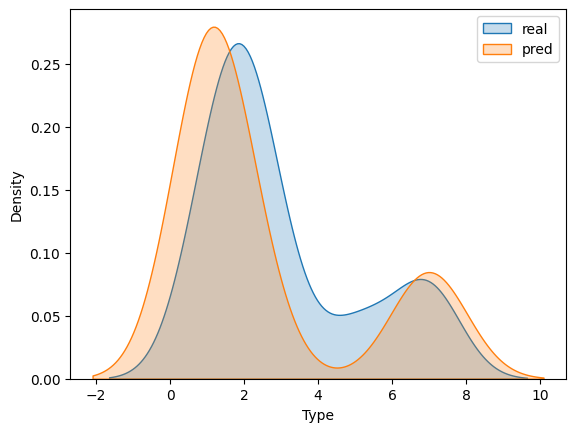

In [153]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(clf.predict(X_test), fill=True, label='pred')
plt.legend()

In [154]:
param_grid = {
    'penalty': ['elasticnet'],
    'l1_ratio': np.linspace(0.00001, 0.99, 10),
    'C':  np.linspace(0.0001, 10.0, 10),
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train, y_train)
best_knn_reg = grid_search.best_estimator_
y_pred = best_knn_reg.predict(X_test)
print(best_knn_reg)
print(classification_report(y_test, y_pred))

LogisticRegression(C=8.8889, l1_ratio=0.99, max_iter=10000,
                   penalty='elasticnet', random_state=17, solver='saga')
              precision    recall  f1-score   support

           1       0.38      0.81      0.52        16
           2       0.57      0.40      0.47        30
           3       0.00      0.00      0.00         8
           5       1.00      0.33      0.50         6
           6       0.00      0.00      0.00         2
           7       0.79      1.00      0.88        11

    accuracy                           0.52        73
   macro avg       0.46      0.42      0.40        73
weighted avg       0.52      0.52      0.48        73



C:\Users\gergi_6afqda2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gergi_6afqda2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gergi_6afqda2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklea

**Підбір гіперпараметрів суттєво нічого не змінив**

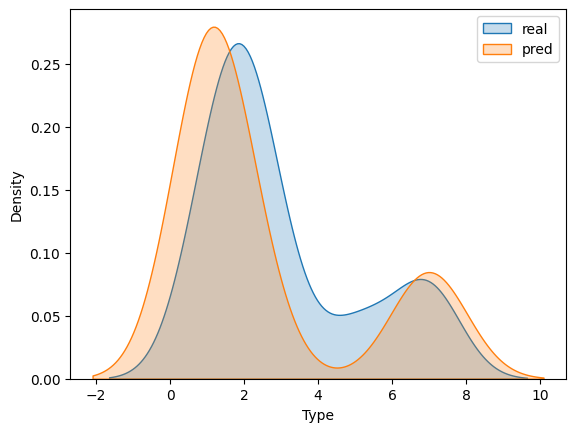

In [155]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(clf.predict(X_test), fill=True, label='pred')
plt.legend()

**Отже, спробувавши усі методи балансуванння на цьому датасеті, найкращий - SMOTEENN семплінг, але інші теж мають доволі гарний перформанс з невеликим відставанням**